In [10]:
import torch

import numpy as np
import os
import random
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.nn import Softmax
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
from segnet import *

In [12]:
image_path = ["C:/Users/Admin/Desktop/car/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B']]
mask_path = ["C:/Users/Admin/Desktop/car/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B']]

In [13]:
import torch

def dice_loss(pred, target, smooth=1e-6):
    # Dự đoán (sau softmax) và nhãn one-hot
    pred = torch.softmax(pred, dim=1)  # [batch_size, num_classes, H, W]
    target = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])  # [batch_size, H, W, num_classes]
    target = target.permute(0, 3, 1, 2)  # [batch_size, num_classes, H, W]

    # Tính Dice Loss
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = 2.0 * intersection / (union + smooth)
    return 1 - dice.mean()  # Dice Loss = 1 - Dice Score

In [14]:
class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, weight_dice=0.5):
        super(DiceCrossEntropyLoss, self).__init__()
        self.weight_dice = weight_dice
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, target):
        # Tính CrossEntropyLoss
        ce = self.ce_loss(logits, target)

        # Tính Dice Loss
        dice = dice_loss(logits, target)

        # Kết hợp hai hàm loss
        return (1 - self.weight_dice) * ce + self.weight_dice * dice


In [15]:
model = Segnet(21, version="s")

In [16]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SDCDataset(Dataset):
    '''
    Dataset lưu trữ ảnh và mask
    '''
    def __init__(self, img_dirs, mask_dirs, transform_img=None, transform_mask=None):
        self.img_dir = img_dirs
        self.mask_dir = mask_dirs
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.image_names = []
        self.mask_names = []
        if type(self.img_dir) == list:
            for i, j in zip(img_dirs, mask_dirs):
                for n in os.listdir(i):
                    self.image_names.append(os.path.join(i, n))
                    self.mask_names.append(os.path.join(j, n))
        else:
            for n in os.listdir(self.img_dir):
                self.image_names.append(os.path.join(self.img_dir, n))
                self.mask_names.append(os.path.join(self.mask_dir, n))

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
    
        img_name = self.image_names[idx]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        mask_name = self.mask_names[idx]
        mask = cv2.imread(mask_name)[:,:,2]
        mask = cv2.resize(mask, (640, 640), interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask).long()
        if self.transform_img:
            image = self.transform_img(image) 
            # mask = self.transform_mask(mask)  

        sample = {'image': image, 'mask': mask}
        return sample

def dataload(image_path, mask_path):

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    

    data_transforms = {
        'Train': transforms.Compose([
            transforms.ToPILImage(),                     
            transforms.Resize((640, 640)),           
            transforms.ToTensor(),           
            transforms.Normalize(mean, std)          
        ]),
        'Test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),

        'Mask': transforms.Compose([
            transforms.ToPILImage(),                   
            transforms.Resize((640, 640)),          
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: x.long())
        ])
    }

    # Dataset cho Train và Test
    image_datasets = {
        'Train': SDCDataset(image_path[:-1], mask_path[:-1], transform_img=data_transforms['Train'], transform_mask=data_transforms['Mask']),
        'Test': SDCDataset(image_path[-1], mask_path[-1], transform_img=data_transforms['Test'], transform_mask=data_transforms['Mask'])
    }

    # DataLoader cho Train và Test
    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
        for x in ['Train', 'Test']
    }
    
    return dataloaders, image_datasets


In [17]:
dataloaders, image_datasets = dataload(image_path, mask_path)

In [ ]:
import csv
import copy
import time
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, roc_auc_score

def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #xm.xla_device() 
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for sample in iter(dataloaders[phase]):
                inputs = sample['image'].to(device)
                # inputs.requires_grad = True 
                masks = sample['mask'].to(device)
                masks = masks.squeeze(1)
                # masks.requires_grad = True 
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    y_pred = torch.argmax(outputs, dim=1).data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
#                     print(y_pred, y_true)
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
#     torch.save(model, os.path.join(bpath, '50epochs_weights.pt'))
    return model

epochs = 1
bpath = "C:/Users/Admin/Desktop/"

# Specify the loss function
criterion = DiceCrossEntropyLoss(weight_dice=0.5)
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Specify the evalutation metrics
metrics = {'f1_score': f1_score} #, 'auroc': roc_auc_score}

trained_model=train_model(model, criterion, dataloaders,optimizer, bpath=bpath, metrics=metrics, num_epochs=epochs)
# xmp.spawn(train_model, args=(model, criterion, dataloaders, optimizer, bpath=bpath, metrics=metrics, num_epochs=num_epochs))

torch.save(trained_model, os.path.join(bpath, f'{epochs}epochs_weights.pt'))

Epoch 1/1
----------


In [10]:
import torch

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    
    return total_params, trainable_params


In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
    

data_transform = {
        'Train': transforms.Compose([
            transforms.ToPILImage(),                     
            transforms.Resize((640, 640)),           
            transforms.ToTensor(),           
            transforms.Normalize(mean, std)          
        ]),
        'Test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),

        'Mask': transforms.Compose([
            transforms.ToPILImage(),                   
            transforms.Resize((640, 640)),          
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.long())
        ])
    }

In [18]:
bpath = "C:/Users/Admin/Desktop/"
epochs = 1
model_path = os.path.join(bpath, f'{epochs}epochs_weights.pt')

if torch.cuda.is_available():
    model = torch.load(model_path)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # xm.xla_device()
# print(device)
# Set the model to evaluate mode
model.eval()

originalImage = cv2.imread("C:/Users/Admin/Desktop/car/dataD/dataD/CameraRGB/02_02_097.png")
temp_img = originalImage
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)

originalImage = data_transform['Train'](originalImage)

In [19]:
with torch.no_grad():
#     a = model(torch.from_numpy(img).to(device).type(torch.FloatTensor)/255)
    if torch.cuda.is_available():
        a = model(originalImage.to(device).unsqueeze(0))
        y_pred = torch.argmax(a, dim=1).squeeze(0).data.cpu().numpy()
    

(-0.5, 639.5, 639.5, -0.5)

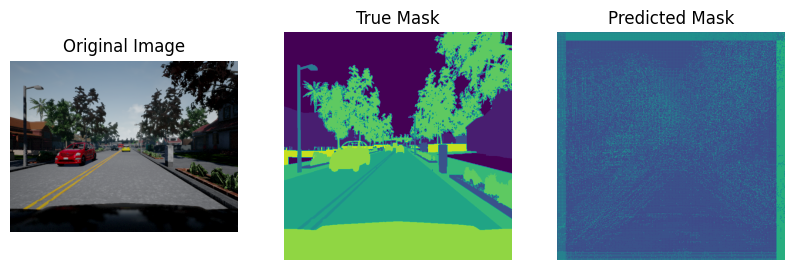

In [20]:
fig, arr=plt.subplots(1,3, figsize=(10,10))

arr[0].imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
arr[0].set_title('Original Image')
arr[0].axis('off')
arr[1].imshow(cv2.resize(cv2.imread('C:/Users/Admin/Desktop/car/dataD/dataD/CameraSeg/02_02_097.png')[:,:,2], (640, 640)))
arr[1].set_title('True Mask')
arr[1].axis('off')
arr[2].imshow(y_pred)
arr[2].set_title('Predicted Mask')
arr[2].axis('off')